In [1]:
from pathlib import Path
import glob
import os

import imgaug.augmenters as iaa

from torch.utils.data import DataLoader
import torch
import torchvision as tv

import pytorch_lightning as pl
from pytorch_lightning.loggers import NeptuneLogger

# Types
from typing import List, Tuple, Optional
import dataclasses
from dataclasses import field
from pydantic.dataclasses import dataclass as pydantic_dataclass
from pydantic import PositiveInt
from pydantic import FilePath, DirectoryPath, confloat

# Mine
from effdet.east import EfficientDetDoesEAST, decode, resizer, EASTLoss
from effdet.east.losses import DiceLoss
from datasets.sroie.dataset import SROIEDataset
from pltraining import EASTUner, parse_yaml, construct_params, grid_from_batch

In [2]:
@pydantic_dataclass
class SROIEDataModule(pl.LightningDataModule):
    
    folderpath: DirectoryPath = field(metadata="Dir containing the image files")
    height: PositiveInt = field(metadata="Height of image")
    width: PositiveInt = field(metadata="Width of image")
    scale: PositiveInt = field(metadata="Scale to downsample the height and width")
    ia_tfms: Optional[iaa.Sequential] = field(default=None, metadata="imgaug augmentations")
    do_gray: bool = field(default=False, metadata="Whether to convert or not to grayscale")
    tfms_decay: Tuple[confloat(ge=.0, le=1.), confloat(ge=.0, le=1.), confloat(ge=.0, le=1.)] = field(default=(0.9, 0.0, 1e-5), metadata="Decay prob of applying augmentation")
    train_bs: PositiveInt = dataclasses.field(default=4, metadata="Training batch size")
    valid_bs: PositiveInt = dataclasses.field(default=4, metadata="Eval batch size")
    num_workers: PositiveInt = dataclasses.field(default=2)
    val_pct: confloat(gt=.0, lt=1.0) = dataclasses.field(default=0.1, metadata="Percentage of data to use for validation")
    

    def __post_init_post_parse__(self,):
        super().__init__()
        self.image_files = sorted(glob.glob(os.path.join(self.folderpath, '*.jpg')))
        
    def train_augs(self,):
        return iaa.Sequential([
            iaa.HorizontalFlip(0.5),
            iaa.VerticalFlip(0.5),
            iaa.OneOf([
                iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30)),
                iaa.Noop()
            ]),
            iaa.OneOf([
                iaa.Grayscale(alpha=(0.0, 1.0)),
                iaa.Noop()
            ]),
            iaa.OneOf([
                iaa.Noop(),
                iaa.GammaContrast((0.5, 1.0))
            ]),
            iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
                rotate=(-5, 5),
                cval=255,
            ),
        ])

    def setup(self, stage):
        if stage == 'fit':
            train_size = round(len(self.image_files) * (1. - self.val_pct))
            self.train_dataset = SROIEDataset(self.image_files[:train_size], 
                                             scale=self.scale,
                                             height=self.height,
                                             width=self.width,
                                             tfms_decay=self.tfms_decay,
                                             do_gray=self.do_gray,
                                             ia_tfms=self.train_augs())
            self.valid_dataset = SROIEDataset(self.image_files[train_size:], 
                                             scale=self.scale,
                                             height=self.height,
                                             width=self.width,
                                             tfms_decay=self.tfms_decay,
                                             do_gray=self.do_gray,)
        if stage == 'test':
            self.test_dataset = self.valid_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.train_bs, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.valid_bs, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.valid_bs, num_workers=self.num_workers)


# HPARAMS
hparams = parse_yaml('hparams.yaml')
params = construct_params(hparams)

# DATA
data_module = SROIEDataModule(**hparams['datamodule'])


In [3]:
# MODEL
model_tuner = EASTUner(**hparams['model'])

Loaded pretrained weights for efficientnet-b6


Refirir ao [EfficientDetDoesEAST](https://github.com/israelcamp/EfficientDetDoesEAST) para mais códigos

In [5]:
_ = model_tuner.model.backbone.backbone_net.requires_grad_(False)

if 'start_from' in hparams:
    checkpoint_path = hparams['start_from']['ckpt_path']
    ckpt = torch.load(checkpoint_path)['state_dict']
    print(model_tuner.load_state_dict(ckpt))
    print(f'Model started from {checkpoint_path}')


# NEPTUNE
neptune_logger = NeptuneLogger(
    offline_mode=True,
    project_name='israelcamp/TextDetection',
    experiment_name='effdet-baseline-cocotext',  # Optional,
    params=params,  # Optional,
    tags=[
        model_tuner.hparams.coef, 
        'advprop' if model_tuner.hparams.advprop else 'imagenet',
        'expand_bifpn' if model_tuner.hparams.expand_bifpn else 'no_expand',
        'factor2' if model_tuner.hparams.factor2 else 'factor4',
        f'scale={data_module.scale}',
        f'repeat_bifpn={model_tuner.hparams.repeat_bifpn}',
        f'bifpn_channels={model_tuner.hparams.bifpn_channels}'
    ],  # Optional,
)


# CALLBACK

filepath = f'SROIE/{neptune_logger.version}' + 'SROIE-effdet-{epoch}-{val_loss:.4f}'
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',
    mode='min',
    save_top_k=2
)

# TRAINER
trainer = pl.Trainer(**hparams['trainer'], logger=neptune_logger, checkpoint_callback=checkpoint_callback, fast_dev_run=True)

# FITTING
trainer.fit(model_tuner, datamodule=data_module)

# model_tuner.logger.experiment.log_artifact('hparams.yaml')

Loaded pretrained weights for efficientnet-b6


Neptune is running in offline mode. No data is being logged to Neptune.
Disable offline mode to log your experiments.
NeptuneLogger will work in offline mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch

  | Name     | Type                 | Params
--------------------------------------------------
0 | model    | EfficientDetDoesEAST | 39 M  
1 | loss_fct | EASTLoss             | 0     


<All keys matched successfully>
Model started from ArTCkps/TD18-ArT-effdet-epoch=19-val_loss=0.1330.ckpt


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

# Checking

In [4]:
ckpt = torch.load('SROIECkps/TD-27SROIE-effdet-epoch=23-val_loss=0.4590.ckpt')
# ckpt = torch.load('ArTCkps/TD18-ArT-effdet-epoch=19-val_loss=0.1330.ckpt')
model_tuner.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [5]:
data_module.setup('fit')
dl_iter = iter(data_module.val_dataloader())

In [22]:
x, y = next(dl_iter)

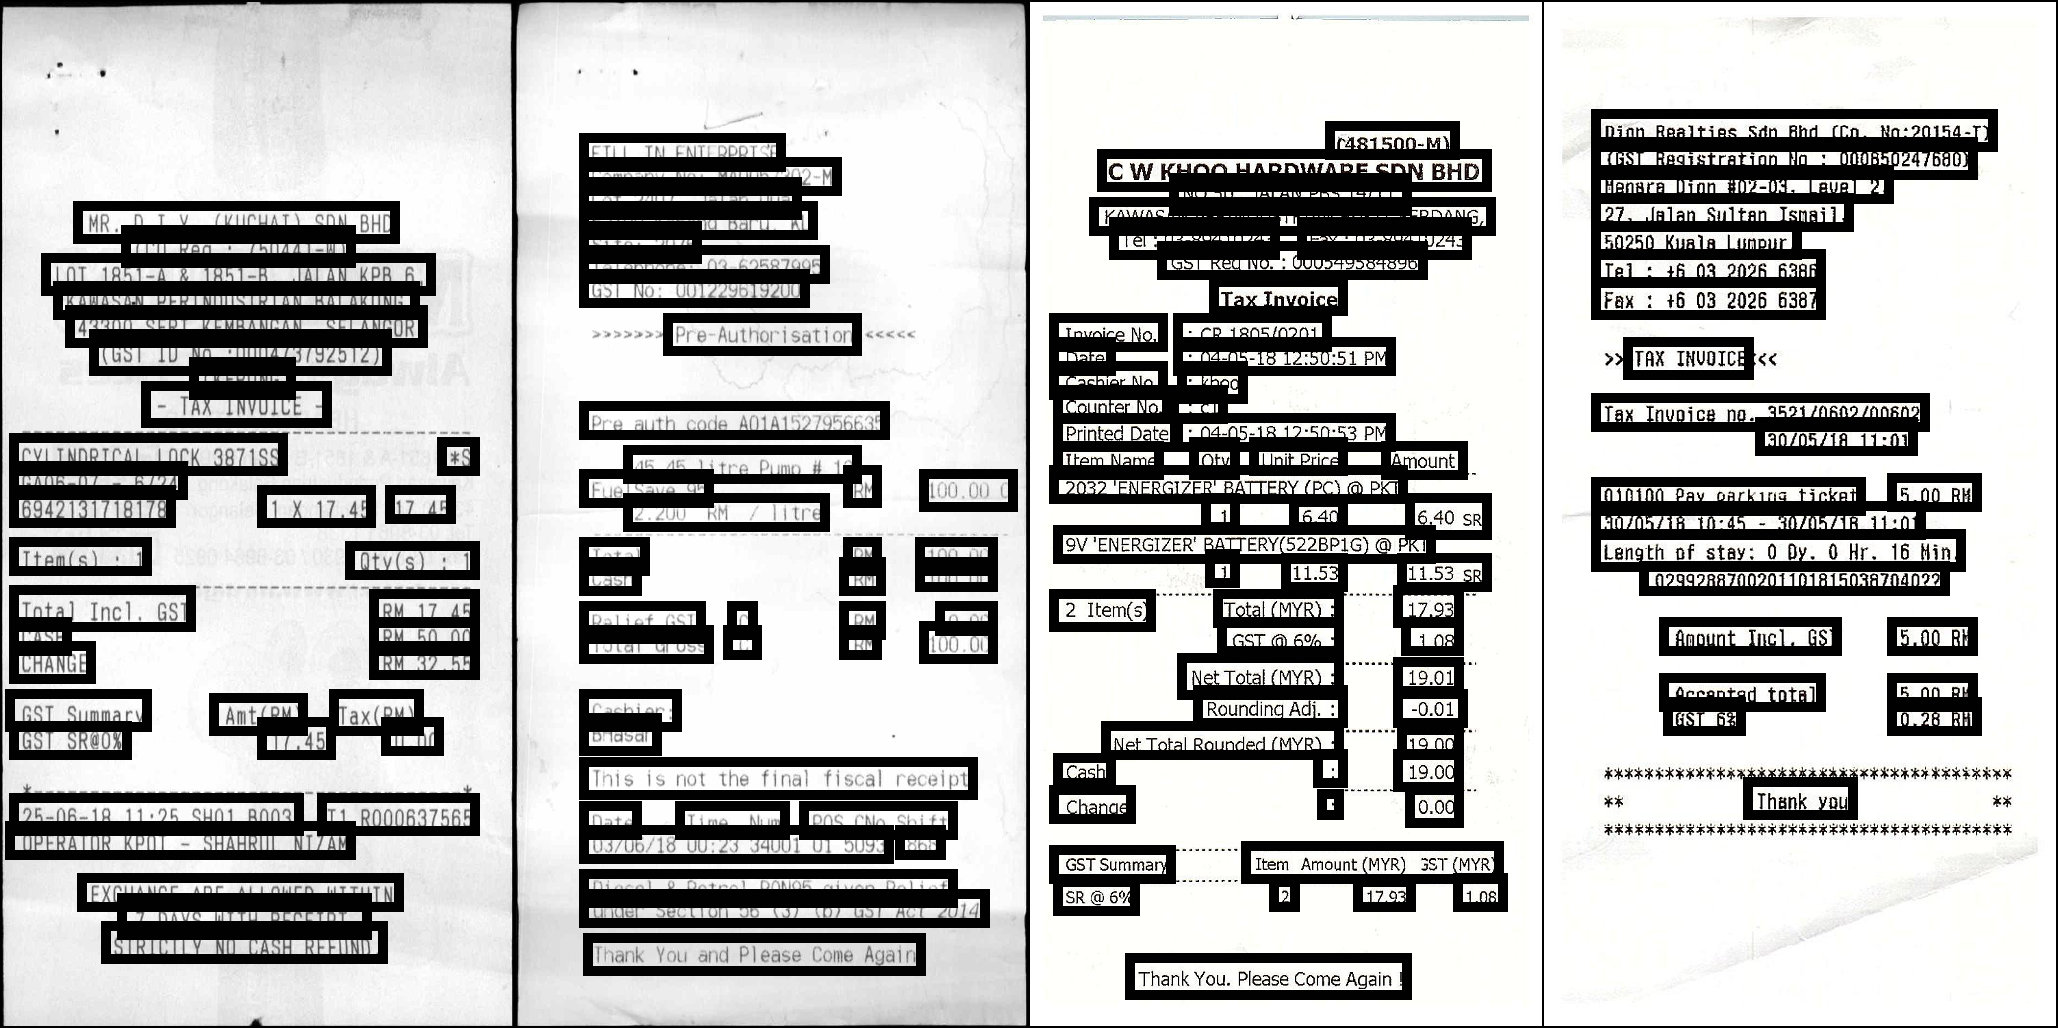

In [23]:
grid = grid_from_batch(x, y)
tv.transforms.ToPILImage()(grid)

In [24]:
model_tuner.eval()
with torch.no_grad():
    _, scores, _ = model_tuner._handle_eval_batch([x, y])

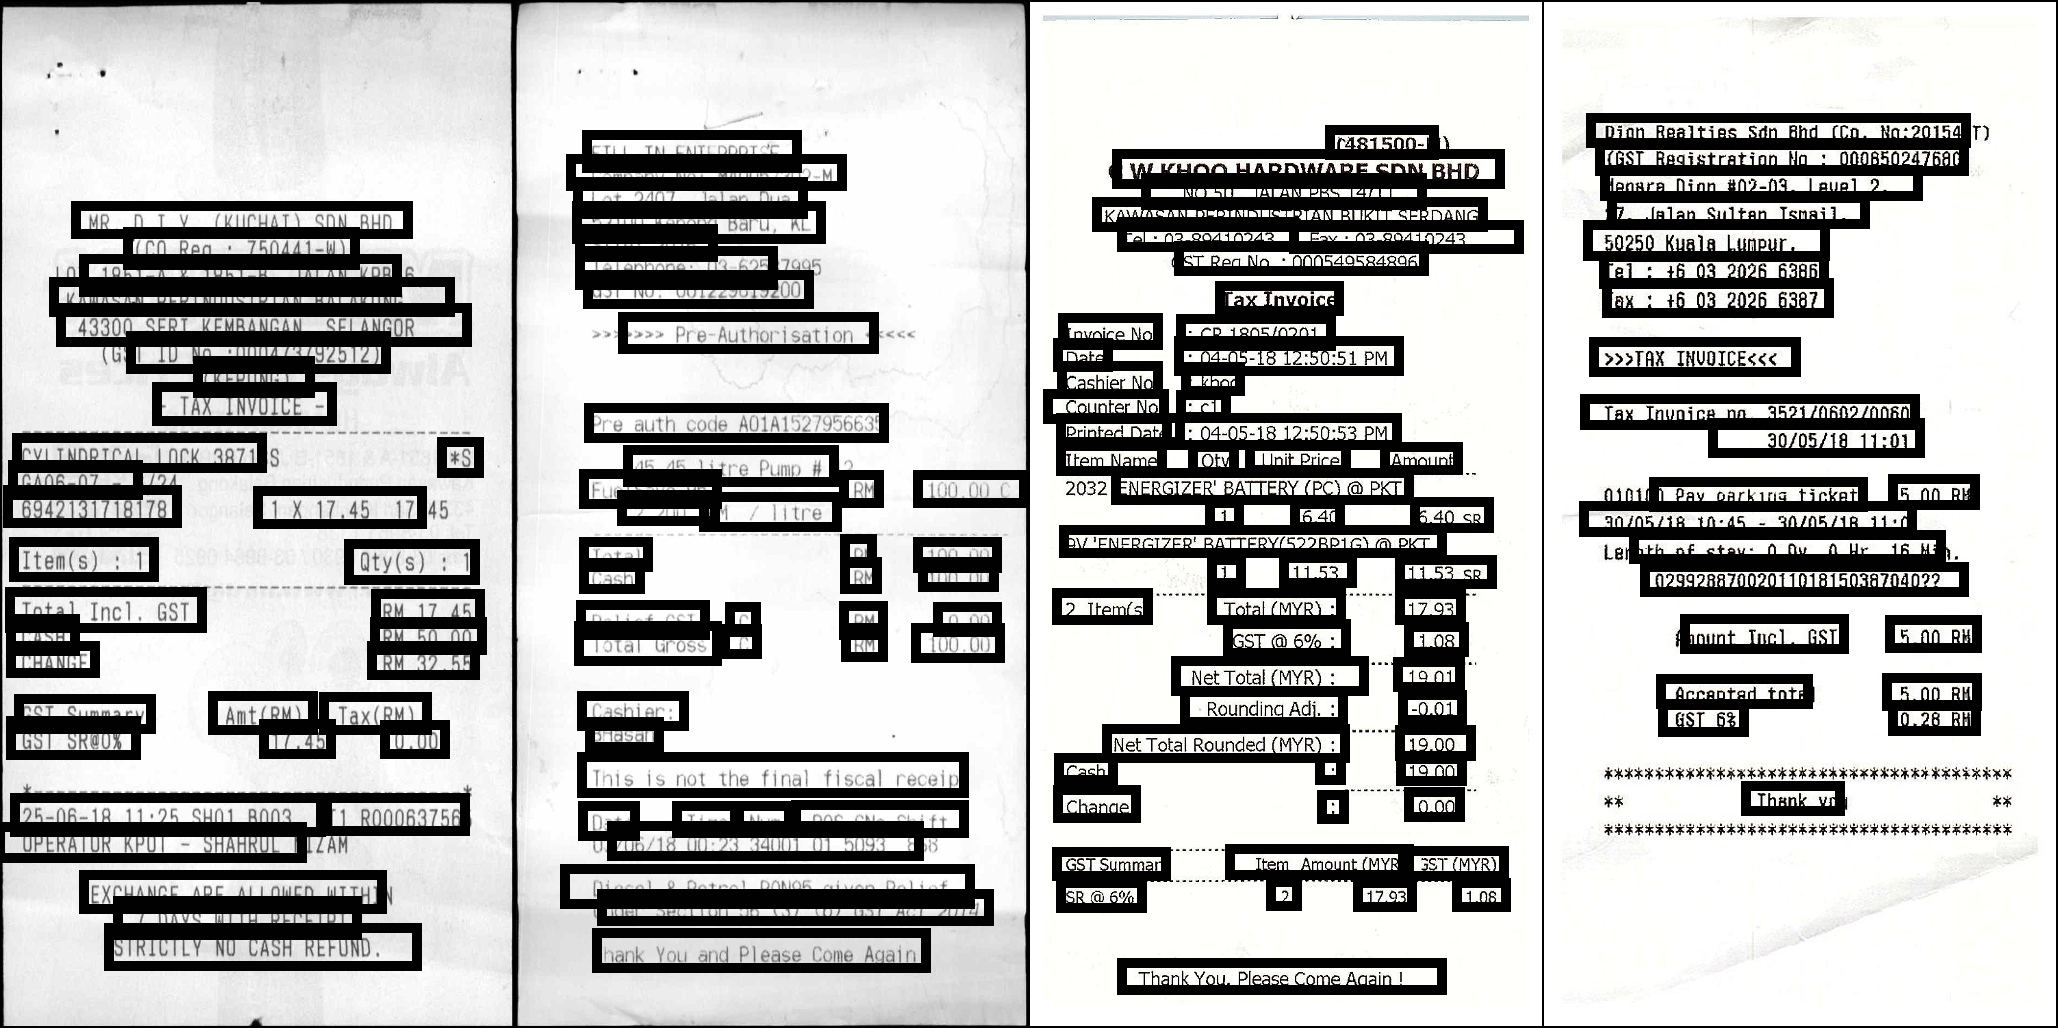

In [25]:
grid = grid_from_batch(x, scores, nms=0.01)
tv.transforms.ToPILImage()(grid)